In [1]:
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('seaborn')
import datetime
from matplotlib.pyplot import MultipleLocator
import h5py
import copy
from MC_file_Sb import MC

In [2]:
#0.15 0.023 147 
(0.07*0.15)/(6*0.088*0.015)

1.325757575757576

In [3]:
np.sqrt(0.15*0.023)

0.05873670062235365

In [4]:
#格点数
# L = 15
L = 20
#层数
Layer_nums=4

warmup = 2e3#预热
updates = warmup+1e3

S=5/2

#exchange coefficient J/k_b. nearest neighbour
J_intraSS = S*0.35*1.602e-22/1.381e-23#0.23
J_intraSS = J_intraSS*1

J_intraQQ = S*0.35*1.602e-22/1.381e-23#0.23
J_intraQQ = J_intraQQ*1

#Magnetocrystalline Anisotropy Energy
K = S*0.07*1.602e-22/1.381e-23#0.07
K=K*0.15

#若负值，层间反铁磁,
J_interSS = -S*0.088*1.602e-22/1.381e-23#0.088
J_interSS = J_interSS*0.015 #for 1610

J_interQQ = S*0.088*1.602e-22/1.381e-23#0.088
J_interQQ = J_interQQ*1

J_interSQ = -S*0.088*1.602e-22/1.381e-23#0.088
J_interSQ = J_interSQ*0.015#*2#1strong SQ PHYS. REV. X 11, 021033 (2021)

#磁场

data_num = 51#26

#uB=5.788*1e-5eV/T
B=S*5.788*2*0.01*1.602e-22/1.381e-23*np.linspace(0.5,-0.5,data_num)

B_real=np.linspace(0.5,-0.5,data_num)
#温度
T=2


#atoms num in evergy unit cell
#atom_num = 2
#3 means the 3 spin  components, s_x,s_y,s_z

# data_spin = np.zeros([Layer_nums,L,L,3])

# for ee in range(Layer_nums):
# 	for ii in range(L):
# 		for jj in range(L):

# 			if ee==0 or ee==3:
# 			#data_spin[ii,jj,kk,:] = np.random.rand(3)*2-1
# 			#tmp = data_spin[ii,jj,kk,:]
# 			#tmp = np.array(tmp)
# 			#data_spin[ii,jj,kk,:] = tmp/np.sqrt(tmp,     tmp)
# 				data_spin[ee,ii,jj,2] = 1.0
# 			else:
# 				data_spin[ee,ii,jj,2] = 0.0

# #引入缺陷																			#这里需要改 会重复
# defects_percent=0.2
# for e in range(Layer_nums):
# 	if e == 0 or e==3:
# 		for i in range(int(L**2*defects_percent)):
# 			L_x=np.random.randint(L)
# 			L_y=np.random.randint(L)
# 			#data_spin[ii,jj,kk,:] = np.random.rand(3)*2-1
# 			#tmp = data_spin[ii,jj,kk,:]
# 			#tmp = np.array(tmp)
# 			#data_spin[ii,jj,kk,:] = tmp/np.sqrt(tmp,     tmp)
# 			data_spin[e,L_x,L_y,2] =0

# 	elif e==1 or e==2:
# 		for i in range(int(L**2*(1-defects_percent/2))):
# 			L_x=np.random.randint(L)
# 			L_y=np.random.randint(L)
# 			#data_spin[ii,jj,kk,:] = np.random.rand(3)*2-1
# 			#tmp = data_spin[ii,jj,kk,:]
# 			#tmp = np.array(tmp)
# 			#data_spin[ii,jj,kk,:] = tmp/np.sqrt(tmp,     tmp)
# 			data_spin[e,L_x,L_y,2] =0

defects_percent=0.2
layer1 = np.random.choice([0, 1], size=(1, L,L,1), p=[defects_percent, 1-defects_percent])#*1.2
layer1 = np.concatenate((np.zeros((1,L,L,2)), layer1), axis=-1)

layer4 = np.random.choice([0, 1], size=(1, L,L,1), p=[defects_percent, 1-defects_percent])
layer4 = np.concatenate((np.zeros((1,L,L,2)), layer4), axis=-1)

layer2 = np.random.choice([0, 1], size=(1, L,L,1), p=[1-defects_percent, defects_percent])#/2
layer2 = np.concatenate((np.zeros((1,L,L,2)), layer2), axis=-1)

# layer3 = np.random.choice([0, 1], size=(1, L,L,1), p=[1-defects_percent, defects_percent])
# layer3 = np.concatenate((np.zeros((1,L,L,2)), layer3), axis=-1)
layer3=layer2


Virtual_boundary=np.zeros((1,L,L,3))
data_spin=np.concatenate((Virtual_boundary,layer1,layer2,layer3,layer4,Virtual_boundary),axis=0)


In [5]:
B_real

array([ 0.5 ,  0.48,  0.46,  0.44,  0.42,  0.4 ,  0.38,  0.36,  0.34,
        0.32,  0.3 ,  0.28,  0.26,  0.24,  0.22,  0.2 ,  0.18,  0.16,
        0.14,  0.12,  0.1 ,  0.08,  0.06,  0.04,  0.02,  0.  , -0.02,
       -0.04, -0.06, -0.08, -0.1 , -0.12, -0.14, -0.16, -0.18, -0.2 ,
       -0.22, -0.24, -0.26, -0.28, -0.3 , -0.32, -0.34, -0.36, -0.38,
       -0.4 , -0.42, -0.44, -0.46, -0.48, -0.5 ])

In [6]:
%%time
#averge magnetization for Z axis
Mag_Z=np.zeros(data_num)
Mag = np.zeros(data_num)

Mag_total = np.zeros(int(updates))

acccept_rate = np.ones((int(data_num),int(updates)))*0.0
sigma = np.ones((int(data_num),int(updates)))*60.0


with h5py.File('SB1610_20size_defect0.2align_2.hdf5', 'w') as f:

	for ii in range(data_num):

		counter = 0

		The_data_spin_collect=[] #记录马氏链进入稳态后的数据
		mc=MC(Layer_nums=Layer_nums,L=L, J_intraSS=J_intraSS, J_intraQQ=J_intraQQ ,J_interSS=J_interSS, J_interSQ=J_interSQ,J_interQQ=J_interQQ ,K=K,B=B[ii],T=T)#,J_intra=J_intra,J_inter=J_inter
		
		for jj in range(int(updates)): 

			
			tmp = mc.Metropolis(data_spin,acccept_rate[ii,jj],sigma[ii,jj])
			data_spin = tmp[0]

			if jj < int(updates)-1:
				acccept_rate[ii,jj+1] = tmp[1]
				sigma[ii,jj+1] = tmp[2]

			# M = mc.Summation(data_spin)
			# #M = np.array(M)

			# M_z=mc.Summation_Z(data_spin)

			#if jj>= warmup and jj%30 == 0:
			if jj>= warmup:
				counter += 1

				The_data_spin_collect.append(copy.deepcopy(data_spin[1:5,:,:,2]))#保存z方向的，注意这边append 

				M = mc.Summation(data_spin)
				Mag[ii] += M
	
				M_z=mc.Summation_Z(data_spin)
				Mag_Z[ii]+=M_z
	

		Mag[ii] = Mag[ii]/counter

		Mag_Z[ii]=Mag_Z[ii]/counter

		#store the spin data
		f.create_dataset(str(B_real[ii])+'T', data=The_data_spin_collect)

		if ii<=5 or ii%10==0:
			print('{} data_spin_for_{}_T is finishied'.format(datetime.datetime.now(),B_real[ii]))

2024-03-20 11:47:36.875238 data_spin_for_0.5_T is finishied
2024-03-20 11:51:49.404016 data_spin_for_0.48_T is finishied
2024-03-20 11:55:54.038683 data_spin_for_0.46_T is finishied
2024-03-20 12:00:15.609703 data_spin_for_0.44_T is finishied
2024-03-20 12:04:25.542495 data_spin_for_0.42_T is finishied
2024-03-20 12:08:54.169237 data_spin_for_0.4_T is finishied
2024-03-20 12:29:57.526836 data_spin_for_0.3_T is finishied
2024-03-20 13:11:04.114514 data_spin_for_0.09999999999999998_T is finishied
2024-03-20 13:51:51.397036 data_spin_for_-0.09999999999999998_T is finishied
2024-03-20 14:33:00.225662 data_spin_for_-0.30000000000000004_T is finishied
2024-03-20 15:12:52.466285 data_spin_for_-0.5_T is finishied
Wall time: 3h 29min 14s


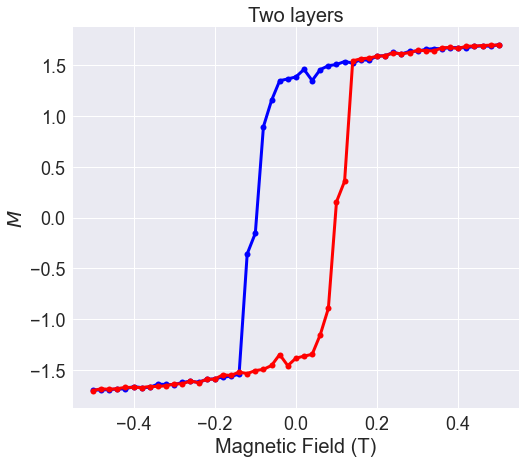

In [8]:
plt.figure(figsize=(8,7))
# B_real=np.linspace(1,-1,data_num)
plt.plot(B_real,Mag_Z,'bo-',markersize=6,lw=3)
plt.plot(-B_real,-Mag_Z,'ro-',markersize=6,lw=3)
plt.xlabel('Magnetic Field (T)',fontsize=20)
plt.ylabel(r'$M$',fontsize=20) 
plt.title('Two layers',fontsize=20)
# plt.xlim(-0.5,0.5)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

# x_major_locator=MultipleLocator(0.2)
y_major_locator=MultipleLocator(0.5)
ax=plt.gca()
# ax.xaxis.set_major_locator(x_major_locator)
ax.yaxis.set_major_locator(y_major_locator)

plt.show()

In [65]:
Mag_Z

array([ 1.56615814,  1.55008232,  1.55338455,  1.56081086,  1.54015037,
        1.54256796,  1.48786516,  1.5319503 ,  1.53340217,  1.51494328,
        1.51740685,  1.49480942,  1.4708962 ,  1.48235289,  1.47200218,
        1.45035544,  1.46359452,  1.42862394,  1.46097795,  1.35558172,
        1.36475997,  1.39450099,  1.35097682,  1.33214597,  1.36283016,
        1.30549218,  1.23741162, -0.05054131, -0.11760289, -0.01191282,
       -1.34435018, -1.45298704, -1.39669777, -1.41221995, -1.45820576,
       -1.42981393, -1.4608093 , -1.46288209, -1.49450016, -1.49052713,
       -1.51136242, -1.49662631, -1.5016995 , -1.52859826, -1.55335517,
       -1.54937732, -1.54300671, -1.56414262, -1.56291884, -1.57177844,
       -1.55380717])

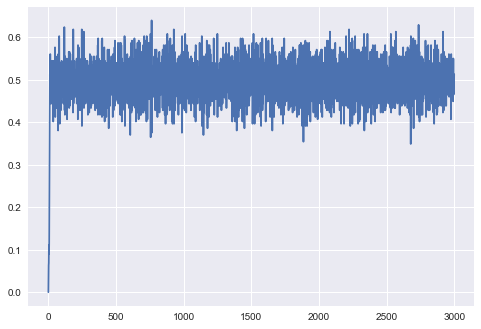

In [66]:
plt.plot(acccept_rate[0])
plt.show()

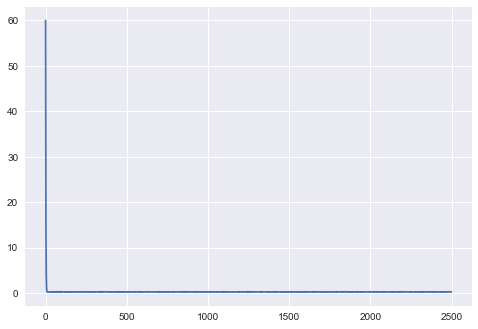

In [17]:
plt.plot(sigma[0])
plt.show()